# Lesson 1

## 1. Objectives

The main objective of this notebook is to replicate the results from the first lesson of Fast AI course (https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb).

I decided to do the following:
1. Create vgg16 model based on vgg16 class. It should be able to distinguish between cats and dogs.
2. Take part in the Dogs vs Cats Kaggle Competition
3. Create vgg16 model which works on some other dataset.

Data should be downloaded from http://files.fast.ai/data/dogscats.zip and put into data directory.

## 2. Setting up

In [1]:
%matplotlib inline
from __future__ import division,print_function

import os, json 
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [2]:
import utils; reload(utils)
from utils import plots

Using TensorFlow backend.
/Users/michalstechly/Documents/Fast_AI/fast-venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## 3. VGG16 - cats and dogs

In [ ]:
# path = os.path.join("..","data","dogscats")
path = os.path.join("..","data","dogscats","sample")

In [ ]:
batch_size = 64

In [ ]:
network = Vgg16()

In [ ]:
train_batches = network.get_batches(os.path.join(path, "train"))
validation_batches = network.get_batches(os.path.join(path, "valid"))
network.finetune(train_batches)

In [ ]:
network.fit(train_batches, validation_batches)

In [ ]:
batches = network.get_batches(os.path.join(path,"train"), batch_size=4)

In [ ]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

## 4. Cats and dogs - Kaggle competition 

In [ ]:
path = os.path.join("..", "dogscats_data")

### 4.1 Setting up directories structure

To download the data follow the instructions: http://wiki.fast.ai/index.php/Kaggle_CLI and put the dat a to the dogscats_data directory.

#### Imports + helper function:

In [ ]:
import glob
import shutil
def safe_mkdir(path):
    """
    Checks if a directory exists. If not, creates it.
    """
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        pass
    except AttributeError as exc:
        pass

#### Creating training and validation set.

Also, puts test data into a structure where we can use get_batches method easily.

In [ ]:
cats_train_path = os.path.join(path, "train_grouped", "cats")
cats_valid_path = os.path.join(path, "valid_grouped", "cats")
safe_mkdir(cats_train_path)
safe_mkdir(cats_valid_path)


dogs_train_path = os.path.join(path, "train_grouped", "dogs")
dogs_valid_path = os.path.join(path, "valid_grouped", "dogs")
safe_mkdir(dogs_train_path)
safe_mkdir(dogs_valid_path)

filenames = glob.glob(os.path.join(path, "train", "*"))

cats_counter = 0
dogs_counter = 0
for filename in filenames:
    name = filename.split("/")[-1]
    if "cat" in name:
        if cats_counter < 3:
            shutil.copy(filename, os.path.join(cats_train_path, name))
            cats_counter += 1
        else:
            shutil.copy(filename, os.path.join(cats_valid_path, name))
            cats_counter = 0
    if "dog" in name:
        if dogs_counter < 3:
            shutil.copy(filename, os.path.join(dogs_train_path, name))
            dogs_counter += 1
        else:
            shutil.copy(filename, os.path.join(dogs_valid_path, name))
            dogs_counter = 0

#### Creating test set.

In [ ]:
filenames = glob.glob(os.path.join(path, "test", "*"))
for filename in filenames:
    name = filename.split("/")[-1]
    file_id = name.split('.')[0]
    test_path = os.path.join(path, "test", file_id)
    safe_mkdir(test_path)
    shutil.move(filename, os.path.join(test_path, name))

### 4.2 Creating and training the network

In [ ]:
batch_size = 64
network = Vgg16()

In [ ]:
train_batches = network.get_batches(os.path.join(path, "train_grouped"), batch_size=batch_size)
validation_batches = network.get_batches(os.path.join(path, "valid_grouped"),batch_size=batch_size)
network.finetune(train_batches)

In [ ]:
number_of_epochs = 3
model_name = "model_2"

In [ ]:
for i in range(number_of_epochs):
    network.fit(train_batches, validation_batches)
    network.model.save_weights(model_name + "_" + str(i) + ".h5")

### 4.2b Alternatively load existing model

In [ ]:
network.model.load_weights("model_1_2.h5")

### 4.3 Make predictions on the testing set

In [ ]:
final_classes = []
final_probabilities = []
final_ids = []
total_number_of_cases = 12500
batch_size = 64

# since get_batches takes images in the order using the method below
all_image_names = sorted(os.listdir(os.path.join(path, "test")))

test_batch = network.get_batches(os.path.join(path, "test"), shuffle=False, batch_size=batch_size)
for i in range(0, int(total_number_of_cases / batch_size) + 1):
    imgs, labels = next(test_batch)
    prediction = network.predict(imgs)
    image_ids = all_image_names[i*64:(i+1)*64]
    image_ids = [int(image_id) for image_id in image_ids]
    probabilities = prediction[0]
    classes = prediction[1]
    final_classes += list(classes)
    final_probabilities += list(probabilities)
    final_ids += image_ids
    if i % 30 == 0:
        print("progress", i*batch_size / total_number_of_cases)

results = np.transpose(np.vstack([final_ids, final_classes, final_probabilities]))
# It changes probabilities for cats to be near 0.
results[results[:,1]==0, 2] = 1 - results[results[:,1]==0, 2]


In [ ]:
np.savetxt(model_name + "_results.csv", results, delimiter=",")

### 4.3b Alternatively load existing results

In [ ]:
results = np.genfromtxt("results.csv",delimiter=",")

### 4.4 Check if the results make sense

In [ ]:
test_batch = network.get_batches(os.path.join(path, "test"), shuffle=False, batch_size=4)
imgs, labels = next(test_batch)
plots(imgs)
results[:4]

### 4.5 Write results to the submission file

In [ ]:
results = results[results[:,0].argsort()]
image_ids = results[:,0]
predictions = np.clip(results[:, 2],0.02,0.98)
with open('submission.csv', 'w') as the_file:
    the_file.write('id,label\n')
    for image_id, prediction in zip(image_ids, predictions):
        the_file.write(str(int(image_id)))
        the_file.write(",")
        the_file.write(str(prediction))
        the_file.write("\n")


In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')

## 5. State Farm Distracted Drivers competition

### 5.1 Setting up directories structure

To download the data follow the instructions: http://wiki.fast.ai/index.php/Kaggle_CLI and put the data to the statefarm directory.
The id for this competition is `state-farm-distracted-driver-detection`

In [4]:
path = os.path.join("..", "data", "statefarm")

#### Imports + helper function:

In [7]:
import glob
import shutil
def safe_mkdir(path):
    """
    Checks if a directory exists. If not, creates it.
    """
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        pass
    except AttributeError as exc:
        pass

#### Creating training and validation set.

Since the training data is already in the correct structure, we just need to extract the validation set from it.
Also, puts test data into a structure where we can use get_batches method easily.

In [ ]:
class_names = ['c'+str(i) for i in range(10)]

validation_path = os.path.join(path, "validation")
safe_mkdir(validation_path)

validation_ratio = 0.2

for class_name in class_names:
    file_paths = glob.glob(os.path.join(path, "train", class_name, "*"))
    validation_paths = np.random.choice(file_paths, int(len(file_paths) * validation_ratio), replace=False)
    safe_mkdir(os.path.join(validation_path, class_name))
    for file_path in validation_paths:
        filename = file_path.split("/")[-1]
        shutil.move(file_path, os.path.join(validation_path, class_name, filename))

#### Creating test set.

In [ ]:
file_paths = glob.glob(os.path.join(path, "test", "*"))
for file_path in file_paths:
    name = file_path.split("/")[-1]
    file_id = name.split('.')[0]
    test_path = os.path.join(path, "test", file_id)
    safe_mkdir(test_path)
    shutil.move(file_path, os.path.join(test_path, name))

#### Creating sample set.

Since the training data is already in the correct structure, we just need to extract the validation set from it.
Also, puts test data into a structure where we can use get_batches method easily.

In [ ]:
sample_path = os.path.join("..", "data", "statefarm", "sample")
class_names = ['c'+str(i) for i in range(10)]

for class_name in class_names:
    for set_name in ["train", "validation"]:
        file_paths = glob.glob(os.path.join(path, set_name, class_name, "*"))
        safe_mkdir(os.path.join(sample_path, set_name, class_name))
        for file_path in file_paths[:4]:
            filename = file_path.split("/")[-1]
            shutil.copy(file_path, os.path.join(sample_path, set_name, class_name, filename))

test_filenames = glob.glob(os.path.join(path, "test", "*")) 
for file_name in test_filenames[:4]:
    print file_name

In [17]:
test_dirpaths = glob.glob(os.path.join(path, "test", "*")) 
for dir_path in test_dirpaths[:4]:
    dir_name = dir_path.split("/")[-1]
    file_name = dir_name + ".jpg"
    file_path = os.path.join(dir_path, file_name)
    safe_mkdir(os.path.join(sample_path, "test", dir_name))
    shutil.copy(file_path, os.path.join(sample_path, "test", dir_name, file_name))

### 5.2 Creating and training the network

In [18]:
batch_size = 64
network = Vgg16()

In [19]:
path = os.path.join("..", "data", "statefarm", "sample")

In [20]:
train_batches = network.get_batches(os.path.join(path, "train"), batch_size=batch_size)
validation_batches = network.get_batches(os.path.join(path, "validation"),batch_size=batch_size)
network.finetune(train_batches)

Found 40 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


In [21]:
number_of_epochs = 1
model_name = "model_1"

In [22]:
for i in range(number_of_epochs):
    network.fit(train_batches, validation_batches)
    network.model.save_weights(model_name + "_" + str(i) + ".h5")

Epoch 1/1
40/40 [==============================] - 181s - loss: 4.7428 - acc: 0.0750 - val_loss: 2.7514 - val_acc: 0.1250
Epoch 1/1
40/40 [==============================] - 178s - loss: 3.6161 - acc: 0.2000 - val_loss: 2.6976 - val_acc: 0.1750
Epoch 1/1
40/40 [==============================] - 187s - loss: 4.1032 - acc: 0.1500 - val_loss: 2.7255 - val_acc: 0.1750


### 5.2b Alternatively load existing model

In [ ]:
network.model.load_weights("model_1_2.h5")

### 5.3 Make predictions on the testing set

In [51]:
final_ids = []
final_predictions = np.array([]).reshape(0,10)
if "sample" in path:
    total_number_of_cases = 4
    batch_size = 1
else:
    total_number_of_cases = 79726
    batch_size = 64

# since get_batches takes images in the order using the method below
all_image_names = sorted(os.listdir(os.path.join(path, "test")))

test_batch = network.get_batches(os.path.join(path, "test"), shuffle=False, batch_size=batch_size)
for i in range(0, int(total_number_of_cases / batch_size) + 1):
    imgs, labels = next(test_batch)
    predictions = network.model.predict(imgs)
    image_ids = all_image_names[i*64:(i+1)*64]
    final_predictions = np.vstack([final_predictions, predictions])
    final_ids += image_ids
    if i % 50 == 0:
        print("progress", i*batch_size / total_number_of_cases)

Found 4 images belonging to 4 classes.
0
progress 0.0
1
2
3
4


### 5.4 Check if the results make sense

Found 4 images belonging to 4 classes.
['img_3064', 'img_31750', 'img_55215', 'img_76097']
[[0.0433 0.076  0.0104 0.3556 0.0047 0.3935 0.0785 0.019  0.0047 0.0143]
 [0.4895 0.0481 0.0395 0.0532 0.0088 0.1639 0.052  0.1005 0.025  0.0195]
 [0.1185 0.0219 0.008  0.0506 0.0126 0.0087 0.1685 0.0211 0.262  0.328 ]
 [0.4627 0.0516 0.0663 0.2065 0.0087 0.0672 0.0676 0.0307 0.0135 0.0251]]


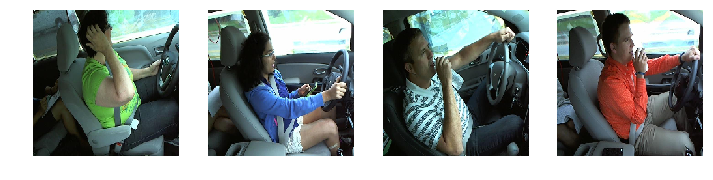

In [53]:
test_batch = network.get_batches(os.path.join(path, "test"), shuffle=False, batch_size=4)
imgs, labels = next(test_batch)
plots(imgs)
print(final_ids[:4])
print(final_predictions[:4])

### 5.5 Write results to the submission file

In [54]:
# predictions = np.clip(results[:, 2],0.02,0.98)
with open('submission.csv', 'w') as the_file:
    the_file.write('img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n')
    for image_id, predictions in zip(final_ids, final_predictions):
        the_file.write(image_id)
        the_file.write(",")
        counter = 0
        for prediction in predictions:
            counter += 1
            the_file.write(str(prediction))
            if counter!=10:
                the_file.write(",")
        the_file.write("\n")


In [55]:
from IPython.display import FileLink
FileLink('submission.csv')

/Users/michalstechly/Documents/Fast_AI/fast_ai_part_1/notebooks/submission.csv